# Homework 3

*This homework was adapted from the STAT 157 course at Berkeley.*

In this homework, we will build a model based real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This notebook contains codes to download the dataset, build and train a baseline model, and save the results in the submission format. Your jobs are 

1. Develope a better model to reduce the prediction error. You can find some hints on the last section. 

2. Submit your results into Kaggle, take a sceenshot of your score, upload it to the image-sharing site of your choice, and embedding it within the notebook (you can use the markdown `![](https://colinraffel.com/images/me.jpg)`, replacing the URL with your uploaded screenshot).

I recommend that you start as early as possible on this homework. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions you can make per day.

You can get a sense of how well you are doing by looking at your position on the Kaggle leaderboard.

Finally, make sure you have a GPU runtime selected!

## Accessing and Reading Data Sets

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition. The data includes multiple datatypes, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'. The price of each house, namely the label, is only included in the training data set (it's a competition after all). The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). Make sure you have `pandas` installed for the experiments in this section.

In [ ]:
!pip install mxnet
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We downloaded the data into the current directory. To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [ ]:
!wget 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv'
!wget 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv'

--2022-01-31 00:15:28--  http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 13.32.207.208
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|13.32.207.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/csv]
Saving to: ‘kaggle_house_pred_train.csv’

kaggle_house_pred_t 100%[===================>] 449.88K  2.16MB/s    in 0.2s    

2022-01-31 00:15:29 (2.16 MB/s) - ‘kaggle_house_pred_train.csv’ saved [460676/460676]

--2022-01-31 00:15:29--  http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 13.32.207.208
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|13.32.207.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451405 (441K

In [ ]:
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

The training data set includes 1,460 examples, 80 features, and 1 label., the test data contains 1,459 examples and 80 features.

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Data Preprocessing

As stated above, we have a wide variety of datatypes. Before we feed it into a deep network we need to perform some amount of processing. Let's start with the numerical features. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$. To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for 'normalizing' the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

In [ ]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# after standardizing the data all means vanish, hence we can set missing values to 0


Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

### Dealing with Missing Value

In [ ]:
def fill_missings(res):
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna('missing')
    res['GarageQual'] = res['GarageQual'].fillna('missing')
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    
    res['BsmtQual'] = res['BsmtQual'].fillna('missing')
    res['BsmtCond'] = res['BsmtCond'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna('missing')
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    
    res['MSZoning'] = res['MSZoning'].fillna('missing')
    res['BsmtFullBath'] = res['BsmtFullBath'].fillna(res['BsmtFullBath'].mode()[0])
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])   
    res['BsmtFinSF1'] = res['BsmtFinSF1'].fillna(0)
    res['BsmtUnfSF'] = res['BsmtUnfSF'].fillna(res['BsmtUnfSF'].mode()[0])
    
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0]) 
    res["Functional"] = res["Functional"].fillna("Typ")
    res["Electrical"] = res["Electrical"].fillna(res["Electrical"].mode()[0])
    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    res['GarageArea'] = res['GarageArea'].fillna(0)
      
    #res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].fillna(0)
    res['MasVnrType'] = res['MasVnrType'].fillna('missing')
    
    return res

In [ ]:
all_features = fill_missings(all_features)

### Convert Ordinal Variables From String to Number

In [ ]:
ordinal_col_dicts = {
    'ExterQual':{'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'ExterCond': {'TA': 3, 'Gd': 2, 'Fa': 4, 'Ex': 1, 'Po': 5},
    'BsmtQual': {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'BsmtCond': {'Fa': 4, 'Gd': 2, 'Po': 5, 'TA': 3,'Ex':1, 'NA':6},
    'BsmtExposure': {'No': 4, 'Av': 2, 'Gd': 1, 'Mn': 3,'NA':5},
    'BsmtFinType1': {'Unf': 6, 'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'NA':7},
    'BsmtFinType2': {'Unf': 6, 'Rec': 4, 'LwQ': 5, 'BLQ': 3, 'ALQ': 2, 'GLQ': 1, 'NA':7},
    'HeatingQC': {'Ex': 1, 'TA': 3, 'Gd': 2, 'Fa': 4, 'Po': 5},
    'CentralAir': {'Y': 1, 'N': 2},
    'Electrical': {'SBrkr': 1, 'FuseA': 2, 'FuseF': 3, 'FuseP': 4, 'Mix': 5},
    'KitchenQual': {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'Functional': {'Typ': 1, 'Min2': 3, 'Min1': 2, 'Mod': 4, 'Maj1': 5, 'Maj2': 6, 'Sev': 7, 'Sal':8},
    'FireplaceQu': {'Gd': 2, 'TA': 3, 'Fa': 4, 'Ex': 1, 'Po': 5},
    'GarageFinish': {'Unf': 3, 'RFn': 2, 'Fin': 1, 'NA':4},
    'GarageQual': {'TA': 3, 'Fa': 4, 'Gd': 2, 'Ex': 1, 'Po': 5},
    'GarageCond': {'TA': 3, 'Fa': 4, 'Gd': 2, 'Po': 5, 'Ex': 1},
    'PavedDrive': {'Y': 1, 'N': 3, 'P': 2},
    'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
    'Utilities': {'AllPub': 1, 'NoSeWa': 3, 'NoSewr':2, 'ELO':4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'BldgType': {'1Fam': 1, 'TwnhsE': 4, 'Duplex': 3, 'Twnhs': 5, '2fmCon': 2},
    'HouseStyle': {'1Story': 1,  '2Story': 4, '1.5Fin': 2, 'SLvl': 8, 'SFoyer': 7, '1.5Unf': 3, '2.5Unf': 6, '2.5Fin': 5},
    'LotConfig': {'Inside': 1, 'Corner': 2, 'CulDSac': 3, 'FR2': 4, 'FR3': 5}
}

def ordinal_encode(data, ordinal_col_dicts): 
    """
    Ordinal encode the ordinal columns according to the values in 
    ordinal_col_dicts.
    """
    for ord_col in ordinal_col_dicts:
        ord_dict = ordinal_col_dicts[ord_col]
        data[ord_col] = data[ord_col].map(ord_dict)
    return data


In [ ]:
all_features_1 = ordinal_encode(all_features, ordinal_col_dicts)
all_features_1 = all_features_1.fillna(0)

In [ ]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
all_features_2 = pd.get_dummies(all_features_1, dummy_na=True)
all_features_2.shape

(2919, 235)

You can see that this conversion increases the number of features from 79 to 331. Finally, via the `values` attribute we can extract the NumPy format from the Pandas dataframe and convert it into MXNet's native representation - NDArray for training.

In [ ]:
n_train = train_data.shape[0]
train_features = nd.array(all_features_2[:n_train].values)
test_features = nd.array(all_features_2[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

### Remove Outliers

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
iF = IsolationForest()
train_features_numpy = train_features.asnumpy()
outlier_indicator = iF.fit_predict(train_features_numpy)
rows_to_delete = []
for i, indicator in enumerate(outlier_indicator):
    if indicator == -1:
        rows_to_delete.append(i)
train_features_numpy = np.delete(train_features_numpy, rows_to_delete, axis=0)
train_labels_numpy = np.delete(train_labels.asnumpy(), rows_to_delete, axis=0)
train_features = nd.array(train_features_numpy)
train_labels = nd.array(train_labels_numpy)


## Training

To get started we train a linear model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

In [ ]:
loss = gloss.L2Loss()

def get_net(p1,p2):
    net = nn.Sequential()
    net.add(nn.Dense(512, activation="relu"),
           nn.Dropout(p1),
           nn.Dense(128, activation="relu"),
           nn.Dropout(p2),
           nn.Dense(1))
    net.initialize(mx.init.Xavier())
    return net

House prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in this competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

In [ ]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

Unlike in the previous sections, the following training functions use the Adam optimization algorithm.  Compared to the previously used mini-batch stochastic gradient descent, the Adam optimization algorithm is relatively less sensitive to learning rates.  This will be covered in further detail later on when we discuss the details on [Optimization Algorithms](../chapter_optimization/index.md) in a separate chapter.

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## k-Fold Cross-Validation

The k-fold cross-validation was introduced in the section where we discussed how to deal with [“Model Selection, Underfitting and Overfitting"](underfit-overfit.md). We will put this to good use to select the model design and to adjust the hyperparameters. We first need a function that returns the i-th fold of the data in a k-fold cros-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [ ]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size, p1, p2):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(p1, p2)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.semilogy(range(1, num_epochs + 1), train_ls)
            plt.semilogy(range(1, num_epochs + 1), valid_ls)
            plt.legend(['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection

We pick a rather un-tuned set of hyperparameters and leave it up to the reader to improve the model considerably. Finding a good choice can take quite some time, depending on how many things one wants to optimize over. Within reason the k-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

fold 0, train rmse: 0.100603, valid rmse: 0.126754
fold 1, train rmse: 0.101703, valid rmse: 0.131001
fold 2, train rmse: 0.097165, valid rmse: 0.132009
fold 3, train rmse: 0.099838, valid rmse: 0.122848
fold 4, train rmse: 0.095990, valid rmse: 0.123325
5-fold validation: avg train rmse: 0.099060, avg valid rmse: 0.127187


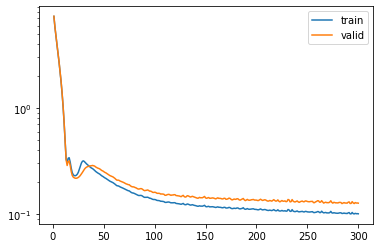

In [ ]:
k, num_epochs, lr, weight_decay, batch_size, p1, p2 = 5, 300, 0.005, 4, 256, 0.6, 0.3
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size, p1, p2)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
     % (k, train_l, valid_l))

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $K$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,p1, p2):
    net = get_net(p1, p2)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.semilogy(range(1, num_epochs + 1), train_ls)
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Let's invoke the model. A good sanity check is to see whether the predictions on the test set resemble those of the k-fold crossvalication process. If they do, it's time to upload them to Kaggle.

train rmse 0.098834


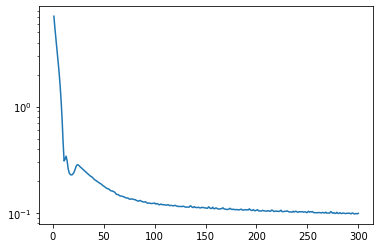

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,p1, p2)

## Submission Result to Kaggle

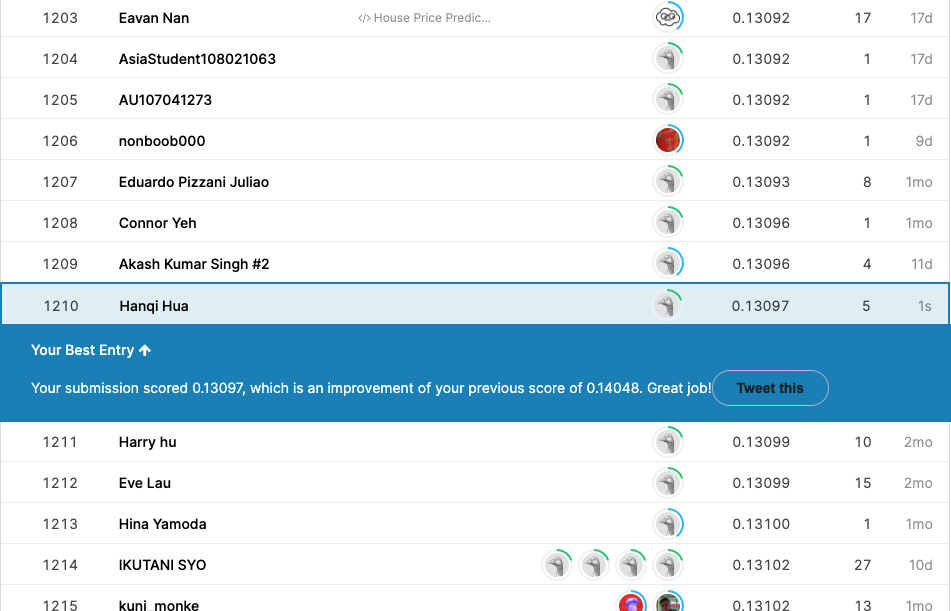

A file, `submission.csv` will be generated by the code above (CSV is one of the file formats accepted by Kaggle). You can find it if you click the folder icon on the left menu in colab. Next, we can submit our predictions on Kaggle and compare them to the actual house price (label) on the testing data set, checking for errors. The steps are quite simple:

* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

## Hints

1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?

1. When I tried the log transformation on price, and minimize the log-price directly, it has a very similar result to the one that we original produced.
2. I replaced the numeric missing value with their mode. For the categorical variables, I've used the value "missing" to indicate in the data.
3. I've tuned the hyperparameters to be the ones that provides the minimum rmse under current model.
4. The model is changed to have two drop-out layers and one output layers. 
5. If we do not standardize the continuous numerical features, the rmse is higher in my case. It is probably because some less significant variables would have higher weights in the model than they should due to their larger numerical scale.

# Acknowledgement

I discussed and collaborated with Yicheng Zou to finish this assignment. \
The code used to remove the outliers is adapted from the code written by Benson Yuan on [GitHub](https://github.com/yuanbenson1772/berkeley-stat-157-deep-learning/blob/master/hw4/homework4.pdf).\
The code used to modify the missing value is adapted from the code written by Zhiming Xu on [GitHub](https://github.com/zhiming-xu/STAT157/blob/master/homework4.ipynb).\
The code used to change the ordinal variables from string to numbers is adapted from the [Kaggle Blog](https://www.kaggle.com/vikassingh1996/extensive-data-preprocessing-and-modeling) by VIKAS SINGH.